In [9]:
!pip install numpy pandas matplotlib scikit-learn tensorflow torch

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MCDropout(nn.Module):
    def __init__(self, p):
        super(MCDropout, self).__init__()
        self.p = p

    def forward(self, x):
        return F.dropout(x, self.p, training=True)  # Keep dropout active during inference


In [3]:
class SimpleNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_p):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.mc_dropout1 = MCDropout(dropout_p)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.mc_dropout2 = MCDropout(dropout_p)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.mc_dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.mc_dropout2(x)
        x = self.fc3(x)
        return x


In [4]:
# Example usage
model = SimpleNet(input_dim=10, hidden_dim=20, output_dim=1, dropout_p=0.5)

# Perform multiple forward passes
def mc_dropout_inference(model, x, num_samples=100):
    model.train()  # Keep dropout active
    outputs = []
    for _ in range(num_samples):
        outputs.append(model(x))
    outputs = torch.stack(outputs)
    mean = outputs.mean(dim=0)
    variance = outputs.var(dim=0)
    return mean, variance


In [8]:
# Input sample
x = torch.randn(1, 10)

# Get prediction and uncertainty estimate
mean, variance = mc_dropout_inference(model, x)

mean_value = mean.item()
variance_value = variance.item()

print("Mean:", mean)
print("Variance:", variance)


Mean: tensor([[-0.1877]], grad_fn=<MeanBackward1>)
Variance: tensor([[0.0228]], grad_fn=<VarBackward0>)


In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

class MCDropout(nn.Module):
    def __init__(self, p):
        super(MCDropout, self).__init__()
        self.p = p

    def forward(self, x):
        return F.dropout(x, self.p, training=True) 


In [25]:
class SimpleNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_p):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.mc_dropout1 = MCDropout(dropout_p)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.mc_dropout2 = MCDropout(dropout_p)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.mc_dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.mc_dropout2(x)
        x = self.fc3(x)
        return x


In [26]:
df = pd.read_csv('MSFT-1.csv')  # Replace with your CSV file path
prices = df['Close'].values 
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices.reshape(-1, 1)).flatten()


In [27]:
X = []
y = []
sequence_length = 5  # Adjust as needed
for i in range(sequence_length, len(prices_scaled)):
    X.append(prices_scaled[i-sequence_length:i])
    y.append(prices_scaled[i])
X = torch.tensor(X, dtype=torch.float32).unsqueeze(2)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)


In [28]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)


In [29]:
model = SimpleNet(input_dim=1, hidden_dim=20, output_dim=1, dropout_p=0.5)  # Corrected input_dim
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs[:, -1, :], y_train)  # Or modify model output 
    loss.backward()
    optimizer.step()


In [30]:
def mc_dropout_inference(model, x, num_samples=100):
    model.train() 
    with torch.no_grad(): 
        outputs = []
        for _ in range(num_samples):
            outputs.append(model(x))
    outputs = torch.stack(outputs)
    mean = outputs.mean(dim=0)
    variance = outputs.var(dim=0)
    return mean.detach().numpy(), variance.detach().numpy()

mean_predictions, variances = mc_dropout_inference(model, X_val)

print("Mean Predictions:", mean_predictions)
print("Variances:", variances)


Mean Predictions: [[[0.07851043]
  [0.082501  ]
  [0.08137445]
  [0.09750762]
  [0.08031451]]

 [[0.08789098]
  [0.08303422]
  [0.07596786]
  [0.07808028]
  [0.07990079]]

 [[0.07286357]
  [0.0776684 ]
  [0.08173584]
  [0.08379299]
  [0.08106058]]

 ...

 [[0.13970484]
  [0.15366417]
  [0.1365232 ]
  [0.1674995 ]
  [0.14796467]]

 [[0.12907748]
  [0.13964178]
  [0.1327398 ]
  [0.14401999]
  [0.1405332 ]]

 [[0.1662133 ]
  [0.16560249]
  [0.1389162 ]
  [0.15620929]
  [0.14034484]]]
Variances: [[[0.00399758]
  [0.00433579]
  [0.00510693]
  [0.00395624]
  [0.004008  ]]

 [[0.00355755]
  [0.0050112 ]
  [0.00429701]
  [0.00453014]
  [0.00340512]]

 [[0.00433774]
  [0.00396454]
  [0.00390276]
  [0.0037671 ]
  [0.00461318]]

 ...

 [[0.0151039 ]
  [0.01687895]
  [0.01747048]
  [0.0208405 ]
  [0.0165178 ]]

 [[0.01563653]
  [0.01609556]
  [0.01396388]
  [0.01565708]
  [0.01648765]]

 [[0.01533624]
  [0.01952993]
  [0.01808663]
  [0.01779699]
  [0.01717659]]]


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

In [9]:
# Generate synthetic data
# Replace with your actual data
data = np.random.rand(100, 1)
labels = np.sin(data).flatten()

# Split data into training and testing sets
train_data, test_data = data[:80], data[80:]
train_labels, test_labels = labels[:80], labels[80:]

# Define LSTM model with dropout
model = keras.Sequential([
    layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True, input_shape=(None, 1)),
    layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2),
    layers.Dense(1)
])

In [10]:
# Compile model
model.compile(loss='mse', optimizer='adam')

# Train model
model.fit(train_data, train_labels, epochs=50, batch_size=16, verbose=0)


In [11]:
# Predictions
predictions = model.predict(test_data)

# Calculate uncertainty using dropout during inference
mc_samples = 100
predictions_mc = np.stack([model.predict(test_data) for _ in range(mc_samples)], axis=0)
mean_prediction = np.mean(predictions_mc, axis=0)
stddev_prediction = np.std(predictions_mc, axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━

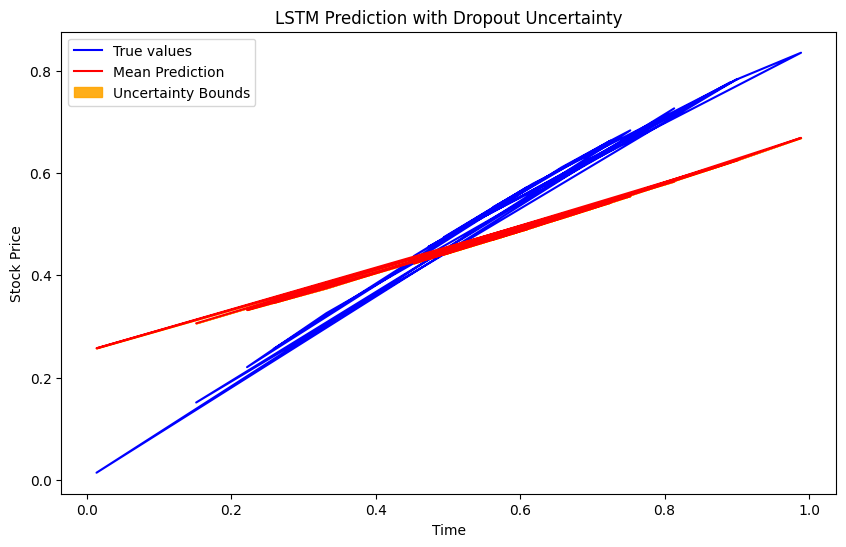

In [14]:
# Visualization
plt.figure(figsize=(10, 6))
plt.plot(test_data, test_labels, label='True values', color='blue')
plt.plot(test_data, mean_prediction, label='Mean Prediction', color='red')
plt.fill_between(test_data.flatten(), 
                 mean_prediction.flatten() - 2 * stddev_prediction.flatten(),
                 mean_prediction.flatten() + 2 * stddev_prediction.flatten(),
                 color='orange', alpha=0.9, label='Uncertainty Bounds')

plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('LSTM Prediction with Dropout Uncertainty')
plt.legend()
plt.show()

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM model


model = Sequential()
model.add(LSTM(50, return_sequences=True,
input_shape=(timestep, features)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')


NameError: name 'features' is not defined

In [18]:
# Assume X_train and y_train are preprocessed datasets
model.fit(X_train, y_train, epochs=50, batch_size=32)


NameError: name 'X_train' is not defined

In [ ]:
import numpy as np

def predict_with_uncertainty(model, X, n_iter=100):
    # Generate multiple predictions with dropout
    predictions = np.array([model(X, training=True) for _ in range(n_iter)])
    prediction_mean = predictions.mean(axis=0)
    prediction_std = predictions.std(axis=0)
    return prediction_mean, prediction_std

# Assume X_test is the test dataset
mean, std = predict_with_uncertainty(model, X_test)


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(true_stock_prices, label='True Prices')
plt.plot(predicted_mean, label='Predicted Prices')
plt.fill_between(range(len(predicted_mean)), predicted_mean - 2*std, predicted_mean + 2*std, color='gray', alpha=0.5, label='Uncertainty')
plt.legend()
plt.show()
